In [2]:
import functools
import os

from absl import app, flags
from einops import rearrange
from flax import jax_utils
from flax.training import orbax_utils, train_state
import jax
import jax.numpy as jnp
from ml_collections import config_flags, ConfigDict
import numpy as np
from orbax.checkpoint import CheckpointManager, CheckpointManagerOptions
from orbax.checkpoint import PyTreeCheckpointer
import optax
from tqdm import tqdm
import wandb

from ddprism import diffusion
from ddprism import linalg
from ddprism import training_utils
from ddprism import utils
from ddprism.metrics import metrics, image_metrics

import datasets
import config_base_grass, config_base_mnist

import matplotlib.pyplot as plt

2025-07-28 14:48:31.029822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753728511.045297  933634 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753728511.050097  933634 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753728511.062586  933634 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753728511.062603  933634 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753728511.062605  933634 computation_placer.cc:177] computation placer alr

In [3]:
def create_posterior_train_state(
    rng, config, config_grass, image_shape, mu_x=None, cov_x=None,
    gaussian=False
):
    "Create joint posterior denoiser."
    learning_rate_fn = training_utils.get_learning_rate_schedule(
        config, config.lr_init_val, config.epochs
    )

    denoiser_models = [
        training_utils.create_denoiser_unet(config_grass, image_shape)
    ]
    if gaussian:
        denoiser_models.append(
            training_utils.create_denoiser_gaussian(config)
        )
    else:
        denoiser_models.append(
            training_utils.create_denoiser_unet(config, image_shape)
        )

    # Joint Denoiser
    feat_dim = image_shape[0] * image_shape[1] * image_shape[2]
    posterior_denoiser = diffusion.PosteriorDenoiserJoint(
        denoiser_models=denoiser_models, y_features=feat_dim * 2,
        rtol=config.post_rtol, maxiter=config.post_maxiter,
        use_dplr=config.post_use_dplr,
        safe_divide=config.get('post_safe_divide', 1e-32),
        regularization=config.get('post_regularization', 0.0),
        error_threshold=config.get('post_error_threshold', None)
    )

    # Initialize posterior denoiser.
    params = posterior_denoiser.init(
        rng, jnp.ones((1, feat_dim * 2)), jnp.ones((1,))
    )
    if mu_x is not None:
        params['params']['denoiser_models_1']['mu_x'] = mu_x
    if cov_x is not None:
        params['params']['denoiser_models_1']['cov_x'] = cov_x

    # Use the new configurable optimizer
    optimizer = training_utils.get_optimizer(config)(learning_rate_fn)
    grad_clip_norm = config.get('grad_clip_norm', 1.0)
    tx = optax.chain(optax.clip_by_global_norm(grad_clip_norm), optimizer)

    return train_state.TrainState.create(
        apply_fn=posterior_denoiser.apply, params=params['params'], tx=tx
    )


In [17]:
print(f'Found devices {jax.local_devices()}')

# Imagenet path.
imagenet_path = '/mnt/home/aakhmetzhanova/ceph/galaxy-diffusion/corrupted-mnist/dataset/grass_jpeg/'

config_grass = config_base_grass.get_config()
config_mnist = config_base_mnist.get_config()
rng = jax.random.key(config_grass.rng_key)

# Grass image shape.
image_shape = (28, 28, 1)

# Set up a train state for sampling later on.
rng_state, rng = jax.random.split(rng)
learning_rate_fn = training_utils.get_learning_rate_schedule(
        config_grass, config_grass.lr_init_val, config_grass.epochs
    )
state_unet = training_utils.create_train_state_unet(
        rng_state, config_grass, learning_rate_fn, image_shape
    )


Found devices [CudaDevice(id=0)]


In [8]:
# Create a sampling function for the prior.
def sample_prior(
        rng, state_local, params_local, image_shape, sample_batch_size,
        sampling_kwargs
    ):
    return utils.sample(
            rng, state_local, {'params': params_local},
            sample_shape=(sample_batch_size,),
            feature_shape=image_shape[0] * image_shape[1] * image_shape[2],
            **sampling_kwargs
        )

## 1. Base grass model.

In [9]:
# Path to grass model.
grass_workdir = '/mnt/home/aakhmetzhanova/ceph/ddprism/corrupted_mnist/train_grass_post_err_thr_0_05/'

checkpointer = PyTreeCheckpointer()
checkpoint_options = CheckpointManagerOptions(
        enable_async_checkpointing=False
    )
checkpoint_manager = CheckpointManager(
        os.path.join(grass_workdir, 'checkpoints'), checkpointer,
        options=checkpoint_options, 
    )

grass_lap = -1 #FLAGS.grass_lap
if grass_lap == -1:
    grass_lap = checkpoint_manager.latest_step()
print(
        f'Loading grass model from {grass_workdir} at checkpoint {grass_lap}.'
    )
restore = checkpoint_manager.restore(grass_lap)
grass_params = restore['ema_params']
grass_state = restore['state']
config_grass = ConfigDict(restore['config'])
checkpoint_manager.close()


Loading grass model from /mnt/home/aakhmetzhanova/ceph/ddprism/corrupted_mnist/train_grass_post_err_thr_0_05/ at checkpoint 31.


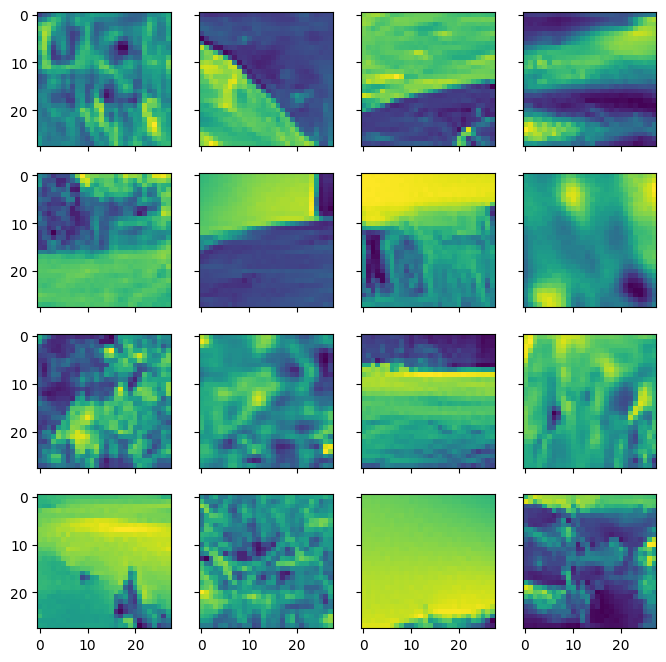

In [12]:
# Get grass samples and plot them.
n_prior_samples = 16

rng_sample, rng = jax.random.split(rng)
prior_samples = sample_prior(
    rng_sample, state_unet, grass_params, image_shape, n_prior_samples, sampling_kwargs=config_grass.sampling_kwargs
    )
prior_samples = prior_samples.reshape(n_prior_samples, image_shape[0], image_shape[1], image_shape[2])

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 8))
for row in range(4):
    for column in range(4):
        axs[row, column].imshow(prior_samples[row*4 + column])


## 2. Downsampled grass model.

In [13]:
# Path to grass model.
grass_workdir = '/mnt/home/aakhmetzhanova/ceph/ddprism/corrupted_mnist/train_grass_downsample/'


checkpointer = PyTreeCheckpointer()
checkpoint_options = CheckpointManagerOptions(
        enable_async_checkpointing=False
    )
checkpoint_manager = CheckpointManager(
        os.path.join(grass_workdir, 'checkpoints'), checkpointer,
        options=checkpoint_options, 
    )

grass_lap = -1 #FLAGS.grass_lap
if grass_lap == -1:
    grass_lap = checkpoint_manager.latest_step()
print(
        f'Loading grass model from {grass_workdir} at checkpoint {grass_lap}.'
    )
restore = checkpoint_manager.restore(grass_lap)
grass_params = restore['ema_params']
grass_state = restore['state']
config_grass = ConfigDict(restore['config'])
checkpoint_manager.close()


Loading grass model from /mnt/home/aakhmetzhanova/ceph/ddprism/corrupted_mnist/train_grass_downsample/ at checkpoint 4.


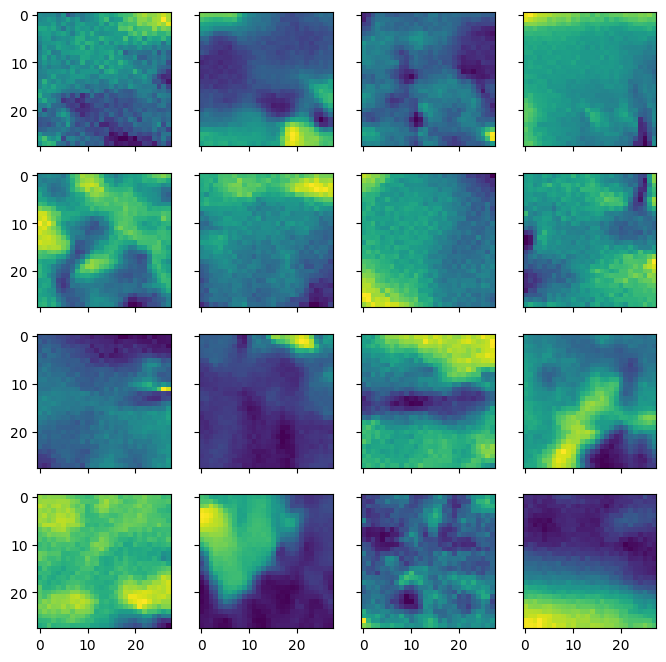

In [14]:
# Get grass samples and plot them.
n_prior_samples = 16

rng_sample, rng = jax.random.split(rng)
prior_samples = sample_prior(
    rng_sample, state_unet, grass_params, image_shape, n_prior_samples, sampling_kwargs=config_grass.sampling_kwargs
    )
prior_samples = prior_samples.reshape(n_prior_samples, image_shape[0], image_shape[1], image_shape[2])

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 8))
for row in range(4):
    for column in range(4):
        axs[row, column].imshow(prior_samples[row*4 + column])


## 3. Base MNIST model.

In [16]:
# Path to grass model.
mnist_workdir = '/mnt/home/aakhmetzhanova/ceph/ddprism/corrupted_mnist/train_mnist/'


checkpointer = PyTreeCheckpointer()
checkpoint_options = CheckpointManagerOptions(
        enable_async_checkpointing=False
    )
checkpoint_manager = CheckpointManager(
        os.path.join(mnist_workdir, 'checkpoints'), checkpointer,
        options=checkpoint_options, 
    )

mnist_lap = -1 #FLAGS.grass_lap
if mnist_lap == -1:
    mnist_lap = checkpoint_manager.latest_step()
print(
        f'Loading MNIST model from {mnist_workdir} at checkpoint {mnist_lap}.'
    )
restore = checkpoint_manager.restore(mnist_lap)
mnist_params = restore['ema_params']
mnist_state = restore['state']
config_mnist = ConfigDict(restore['config'])
checkpoint_manager.close()


Loading MNIST model from /mnt/home/aakhmetzhanova/ceph/ddprism/corrupted_mnist/train_mnist/ at checkpoint 4.


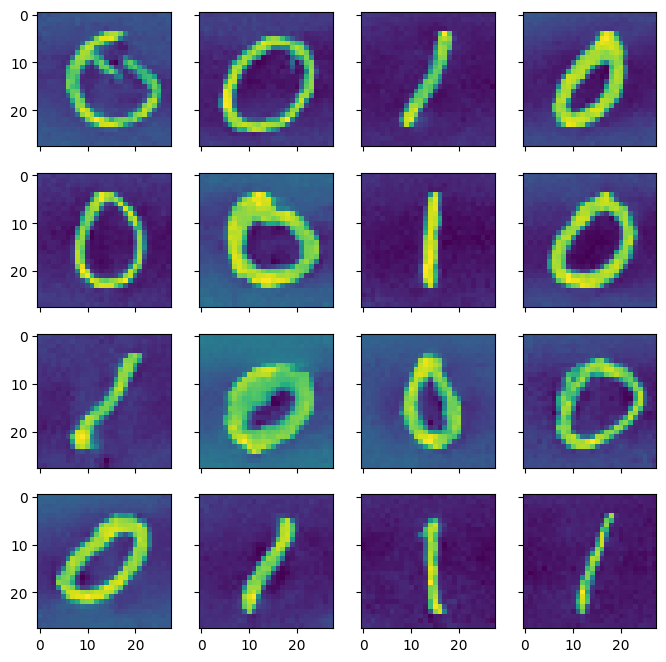

In [18]:
# Get grass samples and plot them.
n_prior_samples = 16

rng_sample, rng = jax.random.split(rng)
prior_samples = sample_prior(
    rng_sample, state_unet, mnist_params, image_shape, n_prior_samples, sampling_kwargs=config_mnist.sampling_kwargs
    )
prior_samples = prior_samples.reshape(n_prior_samples, image_shape[0], image_shape[1], image_shape[2])

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 8))
for row in range(4):
    for column in range(4):
        axs[row, column].imshow(prior_samples[row*4 + column])
